In [1]:
!pip install river

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from river import stream
from river import compose
from river import preprocessing
from river import metrics
#from sklearn import metrics
from river import multiclass
from river import linear_model

In [8]:
tf.__version__

'2.8.0'

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
import matplotlib.pyplot as plt
import time

In [11]:
ls

sample_data/  weight.csv


In [35]:
dataset = pd.read_csv('gru_vae_model.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
dataset.shape

(221, 1)

In [13]:
print(type(y))

<class 'numpy.ndarray'>


In [14]:
print(dataset.columns)

Index(['[[-6.64873049e-02  2.21383236e-02  2.15901877e-03 ...  1.34335995e-01'], dtype='object')


In [15]:
print(X)

[]


In [16]:
print(type(X))

<class 'numpy.ndarray'>


In [17]:
print(type(y))

<class 'numpy.ndarray'>


In [18]:
len(X)

443

In [19]:
print(y)

['   2.16367751e-01  1.96452707e-01]'
 ' [-7.72619396e-02 -5.36395274e-02  1.50474440e-02 ... -1.42972365e-01'
 '   3.99561435e-01  2.41020307e-01]'
 ' [-6.97394088e-02 -1.57618318e-02  8.13613273e-03 ...  1.37171596e-01'
 '   3.95003974e-01  3.61675739e-01]' ' ...'
 ' [ 8.38565007e-02  2.96395482e-03  2.73206104e-02 ... -3.98544706e-02'
 '   2.82704532e-01  2.70962954e-01]'
 ' [ 4.39061001e-02  1.63597777e-03 -3.31184082e-02 ...  3.26564610e-01'
 '   1.77729905e-01  3.52316439e-01]'
 ' [ 1.06034562e-01  8.32484197e-03  2.10149344e-02 ...  3.08683968e+00'
 '   1.01639435e-01  2.84396052e-01]]'
 '[[ 0.04437387 -0.07385865 -0.06818317 ...  0.09145565  0.09075884'
 '   0.0922947 ]'
 ' [-0.14688192 -0.04581044 -0.05627945 ... -0.00832962 -0.2060983'
 '   0.08253089]'
 ' [ 0.02325005 -0.17154774 -0.00207052 ... -0.10317333 -0.00078221'
 '   0.14128648]' ' ...'
 ' [-0.01838543 -0.08110303  0.04868065 ... -0.10681656  0.04247781'
 '   0.29149982]'
 ' [-0.07366685 -0.01885785 -0.01916926 ...  

In [20]:
len(y)

443

In [ ]:
#X and y are numpy nd arrays, so we will be using the stream_ittr option to stream over these values and feed it into river

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [23]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM ,GRU ,RepeatVector,TimeDistributed

# encoder
latent_dim = 14
inter_dim = 32
timesteps, features = 1, 78

def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0] # <================
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

# timesteps, features
input_x = Input(shape= (timesteps, features)) 

#intermediate dimension 
h = GRU(inter_dim, activation='relu')(input_x)

#z_layer
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_sigma])

# Reconstruction decoder
decoder1 = RepeatVector(timesteps)(z)
decoder1 = GRU(inter_dim, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(features))(decoder1)

def vae_loss2(input_x, decoder1, z_log_sigma, z_mean):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(input_x, decoder1))
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma)

    return recon + kl

m2 = Model(input_x, decoder1)
m2.add_loss(vae_loss2(input_x, decoder1, z_log_sigma, z_mean)) #<===========
m2.compile(loss=None, optimizer='adam',metrics='accuracy')

In [25]:
m2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [28]:
tac = time.time()
history = m2.fit(X_train, y_train,validation_data=(X_test, y_test),batch_size=512,epochs=1000,callbacks=[early_stopping])
print(time.time()-tac)

Epoch 1/1000


ValueError: ignored

Minimum validation loss: 0.0659124106168747


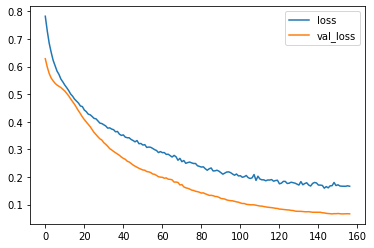

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Maximum validation accuracy: 0.9986245036125183


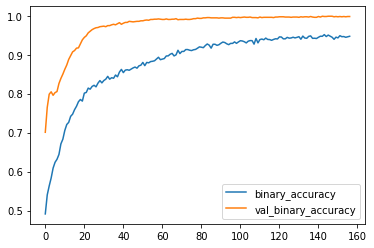

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
print(type(history_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(history_df.columns)

Index(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'], dtype='object')


In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
print(X)

[[15282.  1263. 62174. ...     0.     0.     0.]
 [57854.  1261. 32791. ...     0.     0.     0.]
 [62998.  1261. 61946. ...     0.     0.     0.]
 ...
 [13339.  1263. 60230. ...     0.     0.     0.]
 [19297.  1257. 63203. ...     0.     0.     0.]
 [15461.  1263. 62353. ...     0.     0.     0.]]


In [ ]:
print(type(X[0]))

<class 'numpy.ndarray'>


In [ ]:
#streaming from a numpy array

In [36]:
stream_dataset = stream.iter_array(X, y)

In [37]:
stream_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    multiclass.OneVsRestClassifier(linear_model.PAClassifier())
)

In [38]:
print(stream_model)

StandardScaler | OneVsRestClassifier(PAClassifier)


In [39]:
batch_times = {}
batch_scores = {}
online_times = {}
online_scores = {}
online_sumtimes = {}

In [40]:
#from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#accuracy_score(y_test, y_pred)

In [41]:
metric = metrics.Accuracy()
cm = metrics.ConfusionMatrix()
onlinetrain_no=0
onlinesum=0
start_time=time.time()
y_pred = [0]


for xi, yi in stream_dataset:
  preds = stream_model.predict_one(xi)
  y_pred.append(preds)
  tic=time.time()
  stream_model = stream_model.learn_one(xi, yi)
  iter_time = time.time()-tic
  online_times[onlinetrain_no] = iter_time
  onlinesum+=iter_time
  online_sumtimes[onlinetrain_no]=onlinesum
  metric = metric.update(yi, preds)
  cm = cm.update(yi, preds)
  #metric = metrics.accuracy_score(yi, preds)
  online_scores[onlinetrain_no]= metric.get()
  #the online train no has to be added by one while printing because, it has been started by 0 for the sake of the array #there are 7267 total entries in this dataset, finally to calculate the average the value of total entries which is at 7266(because starts from 0) must be added by 1
  print("INFO] acc update {} - {}".format(onlinetrain_no+1,metric)) 
  print("INFO] training time {} - {} secs\n".format(onlinetrain_no+1,iter_time))
  onlinetrain_no+=1

tot_time = time.time() - start_time
onlinetrain_no+=1
print("\n\n[INFO] final accuracy {}- {}".format(onlinetrain_no,metric))
print("[INFO] total training time - {}".format(tot_time))
print("[INFO] average training time - {}".format(tot_time/onlinesum))


INFO] acc update 1 - Accuracy: 0.00%
INFO] training time 1 - 0.00023436546325683594 secs

INFO] acc update 2 - Accuracy: 0.00%
INFO] training time 2 - 0.00019598007202148438 secs

INFO] acc update 3 - Accuracy: 0.00%
INFO] training time 3 - 0.00014925003051757812 secs

INFO] acc update 4 - Accuracy: 0.00%
INFO] training time 4 - 0.00013017654418945312 secs

INFO] acc update 5 - Accuracy: 0.00%
INFO] training time 5 - 0.0001392364501953125 secs

INFO] acc update 6 - Accuracy: 0.00%
INFO] training time 6 - 0.0001480579376220703 secs

INFO] acc update 7 - Accuracy: 0.00%
INFO] training time 7 - 0.0005254745483398438 secs

INFO] acc update 8 - Accuracy: 0.00%
INFO] training time 8 - 0.00021266937255859375 secs

INFO] acc update 9 - Accuracy: 0.00%
INFO] training time 9 - 0.0001900196075439453 secs

INFO] acc update 10 - Accuracy: 0.00%
INFO] training time 10 - 0.00020551681518554688 secs

INFO] acc update 11 - Accuracy: 0.00%
INFO] training time 11 - 0.00020813941955566406 secs

INFO] acc 

In [42]:
del(y_pred[1])
print(y_pred)

[0, '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.06472468]', '   0.

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
sk_cm = confusion_matrix(y, y_pred)
print(sk_cm)
accuracy_score(y, y_pred)
cl_report = classification_report(y,y_pred)
print(cl_report)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                                                                           precision    recall  f1-score   support

                                                              0.01066703]       0.00      0.00      0.00       1.0
                                                              0.01427254]       0.00      0.00      0.00       1.0
                                                              0.01607804]       0.00      0.00      0.00       1.0
                                                              0.02484433]       0.00      0.00      0.00       1.0
                                                              0.03289911]       0.00      0.00      0.00       1.0
                                                              0.05592759]       0.00      0.00      0.00       1.0
                                                              0.06140234] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
print("actual total training time - {}s".format(onlinesum))

actual total training time - 3.93639874458313s


In [ ]:
#print("actual total training time again - {}s".format(online_sumtimes.values()))

In [ ]:
print(metric.get())

0.9922939314710334


In [ ]:
print(online_scores.values())

dict_values([0.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9655172413793104, 0.9666666666666667, 0.967741935483871, 0.96875, 0.9696969696969697, 0.9705882352941176, 0.9714285714285714, 0.9722222222222222, 0.972972972972973, 0.9736842105263158, 0.9743589743589743, 0.975, 0.975609756097561, 0.9761904761904762, 0.9767441860465116, 0.9772727272727273, 0.9777777777777777, 0.9782608695652174, 0.9787234042553191, 0.9791666666666666, 0.9795918367346939, 0.98, 0.9803921568627451, 0.9807692307692307, 0.9811320754716981, 0.9814814814814815, 0.9818181818181818, 0.9821428571428571, 0.9824561403508771, 0.9827586206896

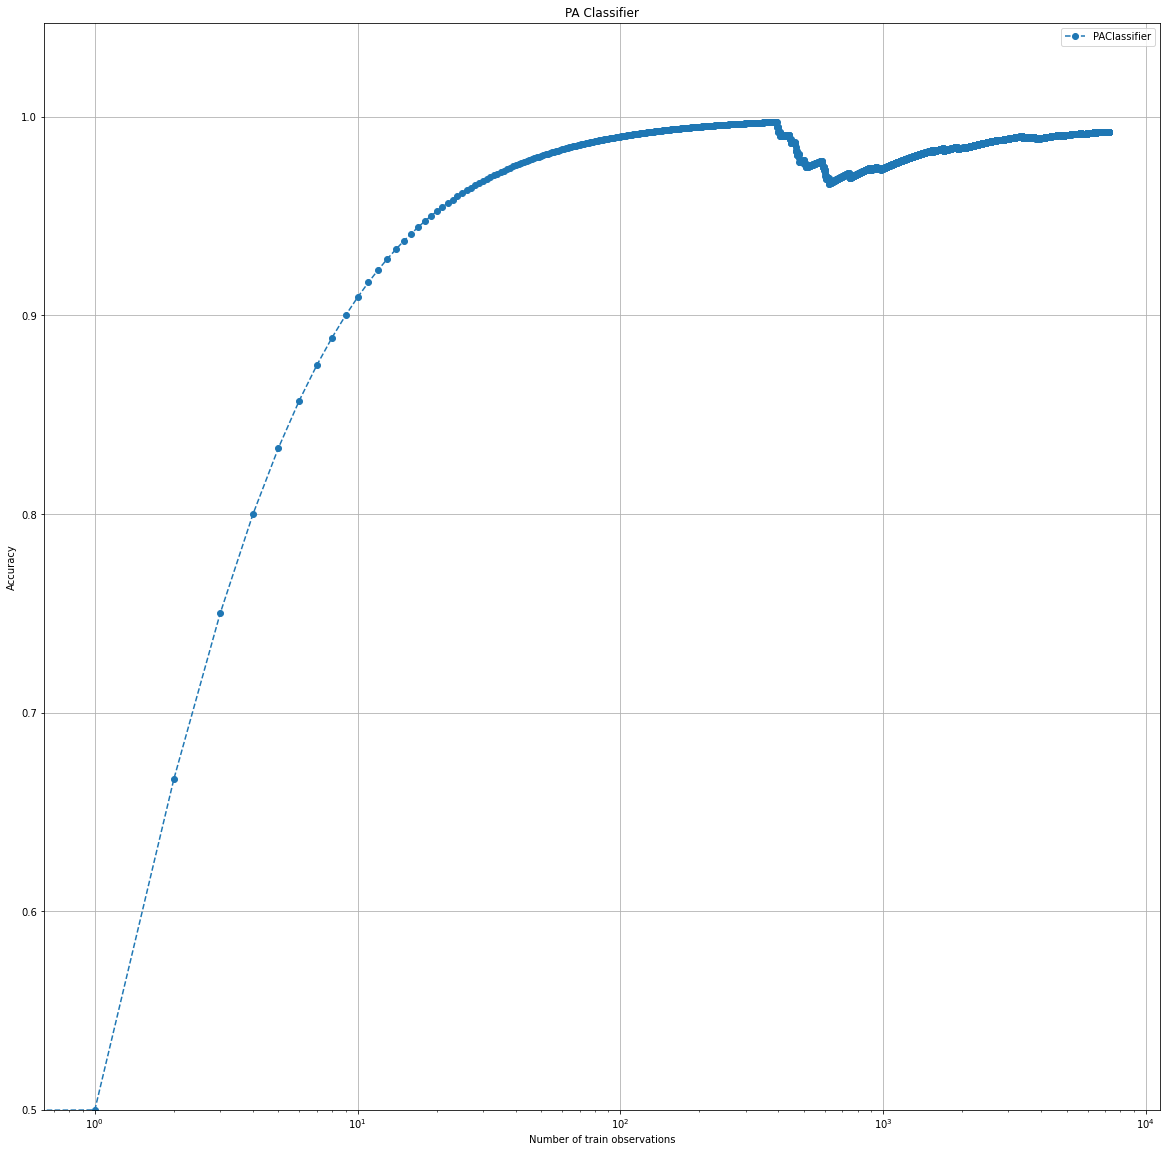

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.plot(batch_scores.keys(), batch_scores.values(), alpha=0.7, marker='o', linestyle='dashed', label='LinearRegression')
ax.plot(list(online_scores.keys()), list(online_scores.values()), alpha=1, marker='o', linestyle='dashed', label='PAClassifier')
ax.set_title('PA Classifier')
ax.set_xscale('log')
ax.set_ylim(0.5)
ax.grid(True)
ax.set_xlabel('Number of train observations')
ax.set_ylabel('Accuracy')
ax.legend();

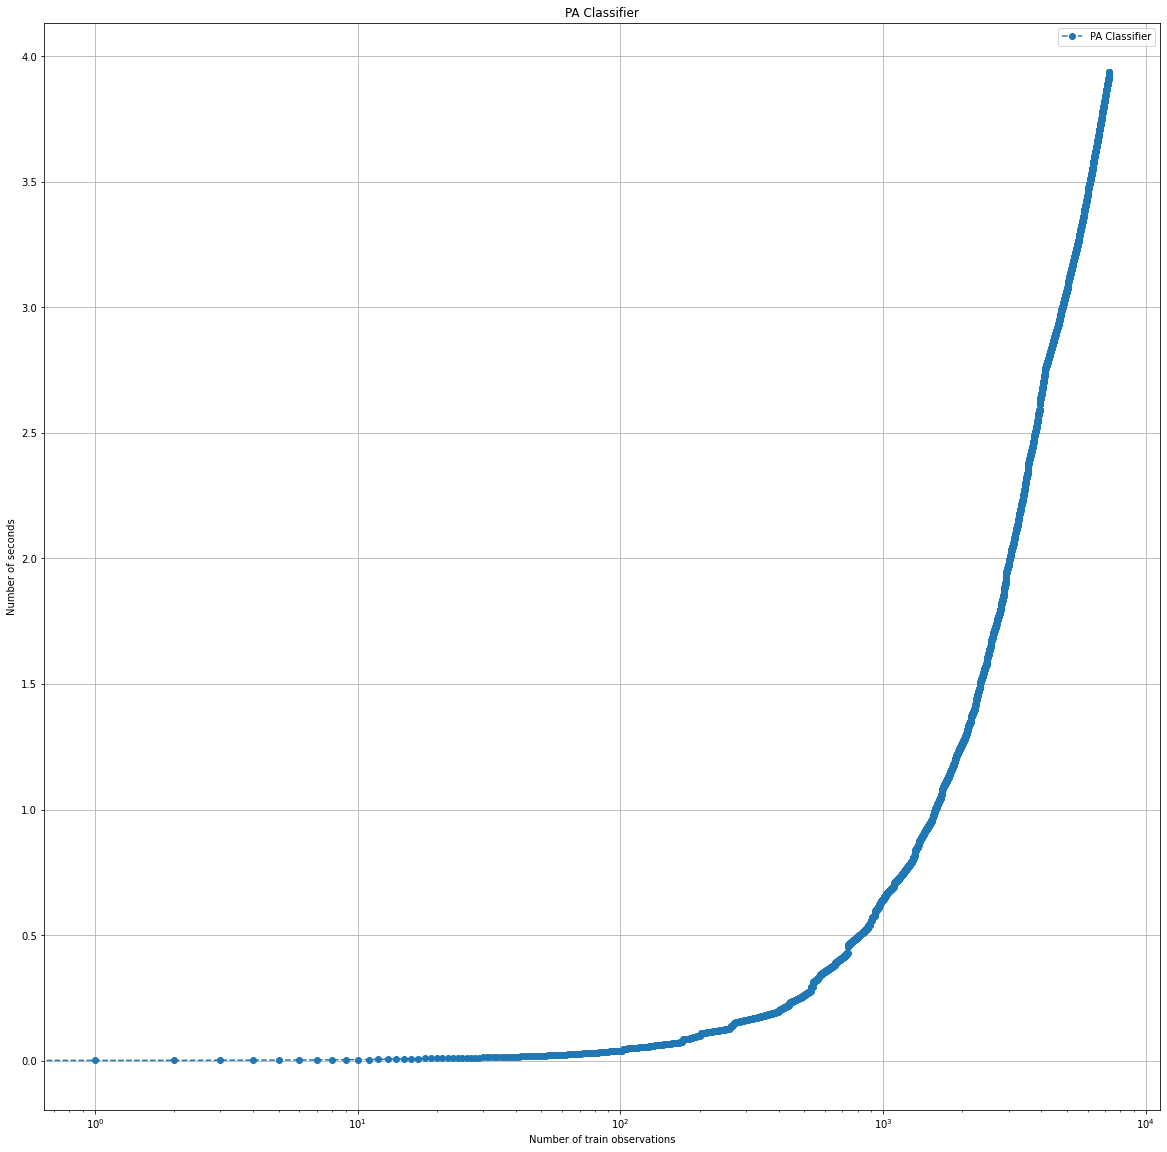

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.plot(batch_times.keys(), batch_times.values(), alpha=0.7, marker='o', linestyle='dashed', label='LogisticRegression')
ax.plot(list(online_times.keys()), list(online_sumtimes.values()), alpha=1, marker='o', linestyle='dashed', label='PA Classifier')
ax.set_title('PA Classifier')
ax.set_xscale('log')
ax.grid(True)
ax.set_xlabel('Number of train observations')
ax.set_ylabel('Number of seconds')
ax.legend();

In [ ]:
 dataset2 = stream.iter_csv('LUNET_out.csv', target="Label")

In [ ]:
stream_model2 = compose.Pipeline(
    preprocessing.StandardScaler(),
    multiclass.OneVsRestClassifier(linear_model.PAClassifier())
)

In [ ]:
print(stream_model2)

In [ ]:
print(type(dataset))

In [ ]:
print(dataset.iloc[:,-1])

In [ ]:
str_dataset = dataset
print(type(str_dataset))

In [ ]:
str_y=str_dataset.iloc[:,-1]
print(type(str_y))

In [ ]:
#streaming from a pandas dataframe

In [ ]:
metric = metrics.Accuracy()

for xi, yi in stream.iter_pandas(str_dataset, str_y):
  preds = stream_model.predict_one(xi)
  stream_model = stream_model.learn_one(xi, yi)
  metric = metric.update(yi, preds)
  print("INFO] acc update - {}".format(metric))


print("[INFO] final - {}".format(metric))



In [ ]:
#this is the supposed code for the csv stream iteration


metric = metrics.Accuracy()

for X,y in enumerate(dataset2):
	preds = stream_model2.predict_one(X)
	stream_model = stream_model.learn_one(X, y)
	metric = metric.update(y, preds)
	print("INFO] update {} - {}".format(i, metric))

print("[INFO] final - {}".format(metric))